# Example Map Plotting

### At the start of a Jupyter notebook you need to import all modules that you will use

In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import cartopy.crs as ccrs                 # For plotting maps
import cartopy.feature as cfeature         # For plotting maps
from cartopy.util import add_cyclic_point  # For plotting maps
import datetime

### Define the directories and file of interest for your results. This can be shortened to less lines as well.

In [2]:
result_dir = "/glade/campaign/acom/acom-weather/emmons/ATom_cesm22/f.e22.FCnudged.f09.cesm220.atom_camsfinn_3tags/atm/hist/"
files = "f.e22.FCnudged.f09.cesm220.atom_camsfinn_3tags.cam.h0.2017*"
#the netcdf file is now held in an xarray dataset named 'nc_load' and can be referenced later in the notebook
nc_load = xr.open_mfdataset(result_dir+files,combine='by_coords',concat_dim='time')
#to see what the netCDF file contains, just call the variable you read it into
#nc_load

### Extract the variable of choice

In [3]:
#extract variable
var_sel = nc_load['CO']/1e-09
print(var_sel)

<xarray.DataArray 'CO' (time: 12, lev: 32, lat: 192, lon: 288)>
dask.array<truediv, shape=(12, 32, 192, 288), dtype=float32, chunksize=(1, 32, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) datetime64[ns] 2017-02-01 2017-03-01 ... 2018-01-01


### Collect variables imporatnt to convert to tcol

In [4]:
#extract grid variables
psurf = nc_load['PS']
hyai = nc_load['hyai']
hybi = nc_load['hybi']
p0 = nc_load['P0']
lev = var_sel.coords['lev']
num_lev = lev.shape[0]

### Convert to total column

### Plot the value over a specific region

In [35]:
# Add cyclic point to avoid white line over Africa
lon = var_sel.lon

In [36]:
var_srf = var_sel.isel(lev=31)
#var_srf = xr.zeros_like(var_sel.isel(time=[0,1,2,3],lev=31))
#var_srf[0,:,:] = var_sel.isel(time=[0,1],lev=31).mean('time')
#var_srf[1,:,:] = var_sel.isel(time=[2,3,4],lev=31).mean('time')
#var_srf[2,:,:] = var_sel.isel(time=[5,6,7],lev=31).mean('time')
#var_srf[3,:,:] = var_sel.isel(time=[8,9,10],lev=31).mean('time')
var_srf_cyc, lon_cyc = add_cyclic_point(var_srf, coord=lon) 
np.squeeze(var_srf_cyc[0,:,:]).shape

(192, 289)

In [37]:
titles = np.array([['DJF','MAM'],['JJA','SON']])

### Plot

In [38]:
#Sub-plots function
def map_subplot(lon,lat,var,contours,colormap,labelbar,position1,position2):
    axs[position1,position2].contourf(lon,lat,var,clev,cmap=colormap,extend=labelbar)
    axs[position1,position2].coastlines()
    #gridlines
    gl = axs[position1,position2].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='grey', 
                                            linewidth=2, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 42, 'color': 'gray'}
    gl.ylabel_style = {'size': 42, 'color': 'gray'}
    #longitude limits in degrees
    axs[position1,position2].set_xlim(-50,90)
    #latitude limits in degrees
    axs[position1,position2].set_ylim(-60,60)
    # add coastlines
    axs[position1,position2].add_feature(cfeature.COASTLINE)
    axs[position1,position2].add_feature(cfeature.LAKES)
    axs[position1,position2].add_feature(cfeature.BORDERS)


0,0
0,1
1,0
1,1


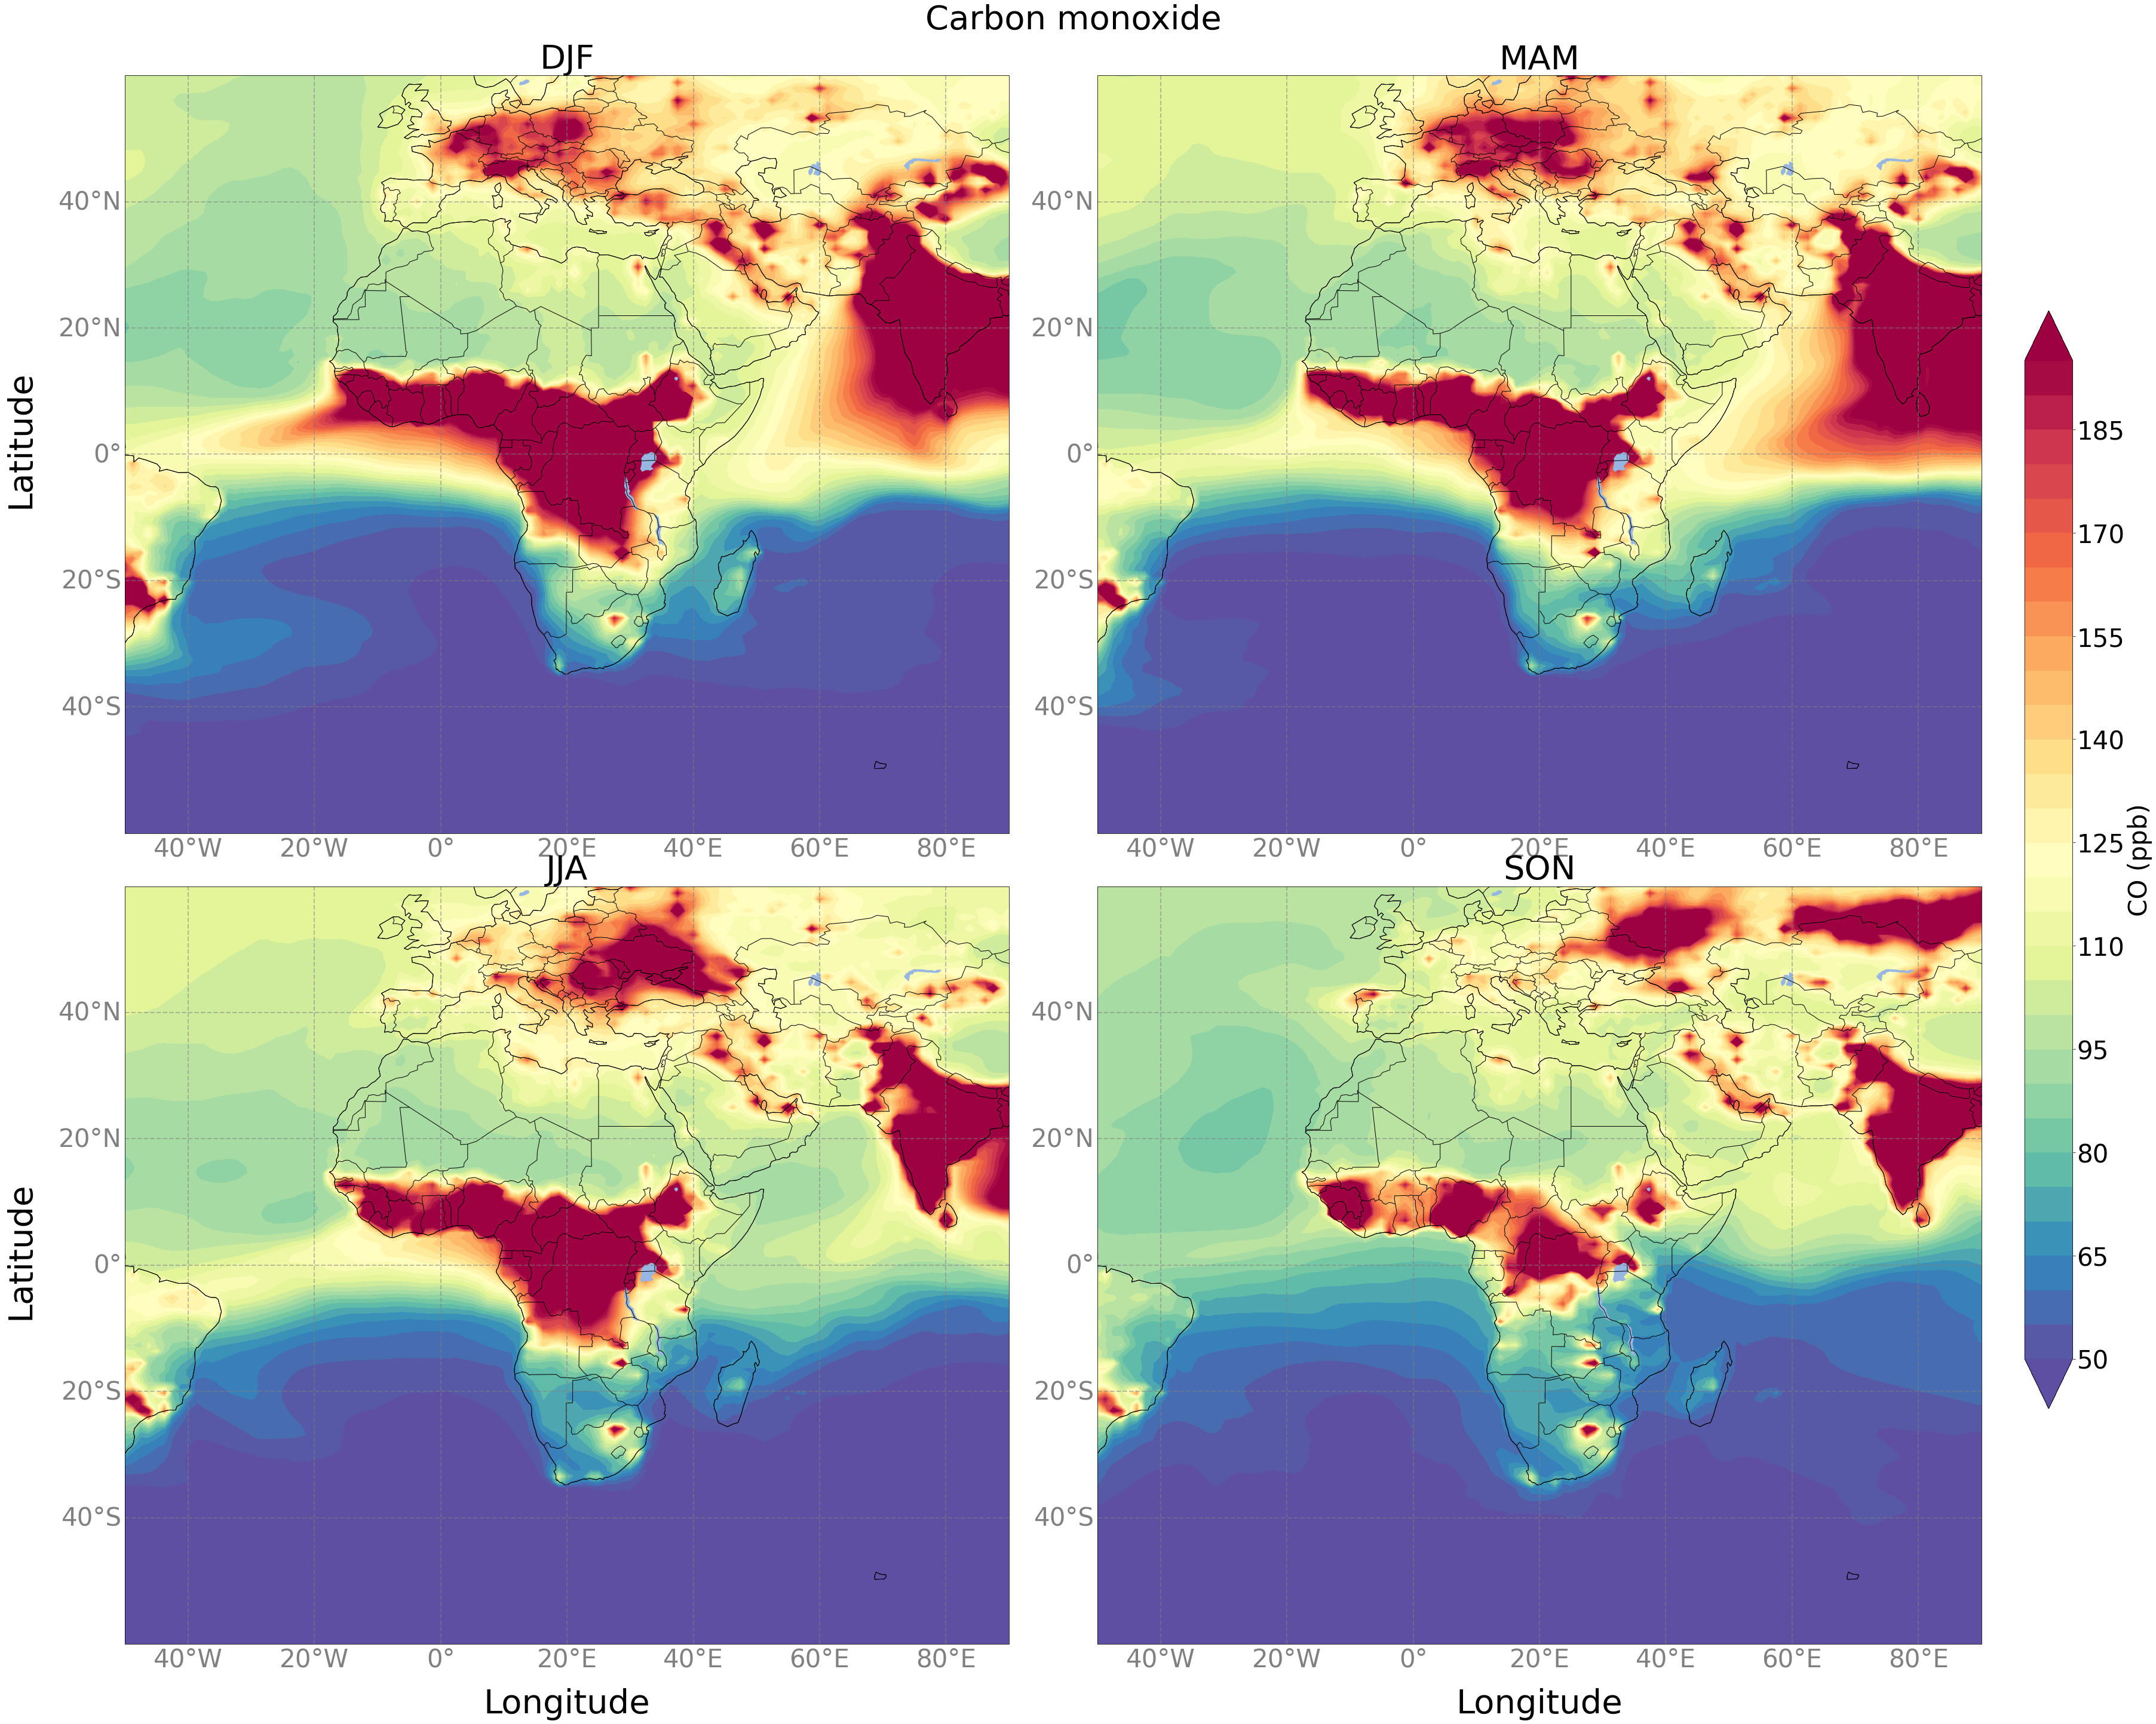

In [39]:
fig, axs = plt.subplots(2,2,figsize=(50,40),
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       constrained_layout=True)

fig.suptitle('Carbon monoxide ', fontsize=56)

#define contour levels
clev = np.arange(50, 200, 5)

for x in range(2):
    for y in range(2):
        print(str(x)+','+str(y))
        season_index = x*2 + y
        map_subplot(lon_cyc,var_sel.lat,var_srf_cyc[season_index,:,:],clev,'Spectral_r','both',x,y)
        #sub-titles
        axs[x,y].set_title(titles[x,y], fontsize=56)
        
#axes
# x-axis
axs[1,0].text(0.50, -0.10, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=axs[1,0].transAxes, fontsize=56)
axs[1,1].text(0.50, -0.10, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=axs[1,1].transAxes, fontsize=56)

# y-axis
axs[0,0].text(-0.10, 0.52, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axs[0,0].transAxes, fontsize=56)
axs[1,0].text(-0.10, 0.52, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axs[1,0].transAxes, fontsize=56)

# colorbar
cbar_set = axs[0,0].contourf(lon_cyc,var_sel.lat,var_srf_cyc[0,:,:],clev,cmap='Spectral_r',extend='both')
cb = fig.colorbar(cbar_set, ax=axs[:, 1], shrink=0.7)
cb.set_label(label='CO (ppb)', fontsize=42)
cb.ax.tick_params(labelsize=42)

plt.show()